<a href="https://colab.research.google.com/github/davideliseo/lab-3-ia/blob/main/lab_3_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. https://www.tensorflow.org/tutorials/load_data/images
2. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
3. https://www.tensorflow.org/api_docs/python/tf/data/Dataset




# **Librerias**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools
import os
import h5py
import PIL as pillow

import tensorflow as tf
from tensorflow import keras as k
from keras import layers

# 1. Fase 0: Formulación del dataset

In [ ]:
from google.colab import drive

# Monta la unidad de Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Ruta base de la aplicación.
path = "/content/drive/Shareddrives/IA/Lab 3"

# Ruta del dataset
images_path = os.path.join(path, "dataset")

# Ruta del dataset exportado
dataset_path = os.path.join(path, "out/dataset/tools_dataset.h5")

# Ruta del dataset exportado
augmented_dataset_path = os.path.join(path, "out/dataset/augmented_tools_dataset.h5")

In [ ]:
# Dimensión normalizada de las imágenes
image_size = (224, 224)

## 1.1 Construcción

In [ ]:
def split_idx(iterable, split: float = 0.0):
  return int(len(iterable) * (1.0 - split))


def split_dataset(images, labels, split: float = 0.0):
  """
  Divide el dataset en dos partes, según el parámetro `split`. 
  """
  
  idx = split_idx(images, split)
  left_images = images[:idx]
  left_labels = labels[:idx]

  right_images = images[idx:]
  right_labels = labels[idx:]

  return (left_images, left_labels), (right_images, right_labels)


def zip_apply(fn, *iterables):
  """
  Aplica una función a un conjunto de listas en el mismo orden.
  """
  zipped = list(zip(*iterables))
  applied = fn(zipped)
  return zip(*applied)


def zip_shuffle(*iterables: list[np.ndarray]):
  """
  Revuelve un conjunto de listas en el mismo orden.
  """
  return zip_apply(lambda x: random.sample(x, k=len(x)), *iterables)

In [ ]:
def preprocess_dataset_image(image_path: str) -> np.ndarray:
  image = pillow.Image.open(image_path)
  image = image.convert("RGB")
  image = image.resize(image_size)
  return np.array(image).astype(np.uint8)


def directory_file_paths(directory: str):
  return (
    full_file_path 
    for file_path in os.listdir(directory) 
    if os.path.isfile(full_file_path := os.path.join(directory, file_path))
  )
  

def subdirectories(root: str):
  _, dirs, _ = next(os.walk(root))
  return sorted(dirs)


def make_dataset(root: str, shuffle: bool = True, max_per_class: int = None):
  images, labels = [], []
  classes = subdirectories(root)

  for (class_idx, class_name) in enumerate(classes):
    class_path = os.path.join(images_path, class_name)
    file_paths = directory_file_paths(class_path)

    if max_per_class:
      file_paths = itertools.islice(file_paths, max_per_class)

    for file_path in file_paths:
      images.append(image := preprocess_dataset_image(file_path))
      labels.append(label := class_idx)

  if shuffle:
    return *zip_shuffle(images, labels), classes
  
  return images, labels, classes

# 1.2 Exportación e importación

In [ ]:
def save_dataset(images, labels, classes, path: str):
  with h5py.File(path, "w") as hf:
    hf.create_dataset("images", np.shape(images), data=images)
    hf.create_dataset("labels", np.shape(labels), data=labels)
    hf.create_dataset("classes", np.shape(classes), data=classes)

In [ ]:
def capped(iterable, cap: float = None):
  if not cap:
    return iterable
    
  size = len(iterable)
  idx = np.clip(cap, 1, size)
  iterable = iterable[:idx]
  return iterable


def sliced(iterable, start: float | int = 0, stop: float | int = None):
  size = len(iterable)

  if isinstance(start, float):
    start = round(size * start)
  if isinstance(stop, float):
    stop = round(size * stop)
  else:
    stop = np.clip(1 if stop is None else stop, 1, size)

  size = len(iterable)
  return iterable[start:stop]

In [ ]:
sliced([1, 2, 3], 0, 0.4)

[1]

In [ ]:
def load_dataset(
  path: str,
  augmented_path: str = None,
  cap: int = None,
  split: float = None,
  shuffle: bool = True
):
  def load(path: str):
    if not os.path.isfile(path):
      raise FileNotFoundError(f"El archivo no existe: {path}")

    with h5py.File(path, "r+") as hf:
      images = hf["/images"]
      labels = hf["/labels"]

      if shuffle:
        images, labels = zip_shuffle(images, labels)

      images = np.array(images).astype(np.uint8)
      labels = np.array(labels).astype(np.uint8)

      classes = hf["/classes"]
      classes = list(map(lambda cn: cn.decode("utf-8"), classes))

      if not split:
        return images, labels, classes

      return *split_dataset(images, labels, split), classes

  original_images, original_labels, classes = load(path)
  if not augmented_path:
    original_images = capped(original_images, cap)
    original_labels = capped(original_labels, cap)
    return original_images, original_labels, classes

  augmented_images, augmented_labels, _ = load(augmented_path)
  
  images = np.concatenate((original_images, augmented_images))
  labels = np.concatenate((original_labels, augmented_labels))

  images = capped(images, cap)
  labels = capped(labels, cap)
  return images, labels, classes
  

In [ ]:
force_export = False  # `True` para forzar la creación del dataset, `False` para ocupar el dataset exportado
exported = os.path.isfile(dataset_path)  # Determina si el dataset ha sido exportado previamente

if did_export := (force_export or not exported):
  dataset = make_dataset(root=images_path, max_per_class=None)
  save_dataset(*dataset, path=dataset_path)
  exported = True

In [ ]:
if exported:
  images, labels, classes \
  = load_dataset(
    path=dataset_path,
    augmented_path=augmented_dataset_path, 
    cap=7500,
    shuffle=True
  )

  print("Dimensión de imágenes:", images.shape)
  print("Dimension de etiquetas:", labels.shape)
  print(classes)

Dimensión de imágenes: (7500, 224, 224, 3)
Dimension de etiquetas: (7500,)
['axe', 'claw_hammer', 'drill', 'handsaw', 'measuring_tape', 'paint_brush', 'pliers', 'screwdriver', 'shovel', 'square_tool']


In [ ]:
def decode_class_name(class_name: str) -> int:
  return classes.index(class_name)

In [ ]:
def display(image: np.ndarray, label: int = None, grayscale: bool = False):
  if grayscale:
    image = image[:, :, 0]  # Selecciona el 1er canal de la imagen

  plt.imshow(image, cmap="gray")  # El colormap en escala de grises es ignorado si la imagen es RGB(A)
  plt.axis("off")

  if label:
    plt.title(label)

  plt.show()


def random_image(images, labels):
  idx = random.randrange(len(images))
  return images[idx], labels[idx]


def display_random(images, labels):
  image, label = random_image(images, labels)
  display(image, label=classes[label])


def display_grid(images, labels, n: int = 1):
  plt.figure(figsize=(6, 7))
  for i in range(n):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype(np.uint8))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [ ]:
if did_export:
  def test_dataset_integrity():
    images, labels, classes = dataset
    idx = random.randrange(len(images))
    display(images[idx], label=classes[labels[idx]])
    
    # Para que ambos datasets sean iguales, el exportado debe cargarse sin revolver
    images, labels, classes = load_dataset(path=dataset_path, shuffle=False)
    display(images[idx], label=classes[labels[idx]])

  test_dataset_integrity()

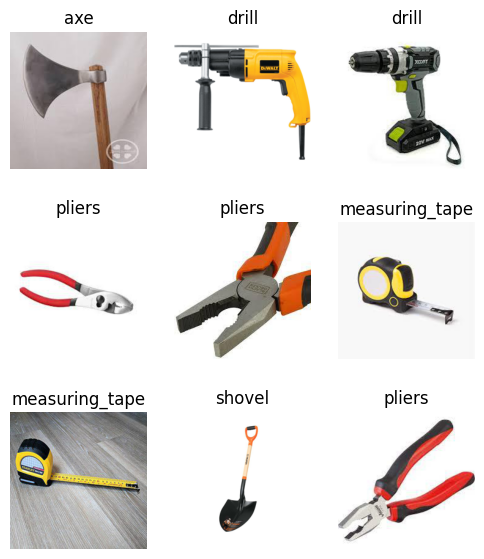

In [ ]:
display_grid(images, labels, n=9)

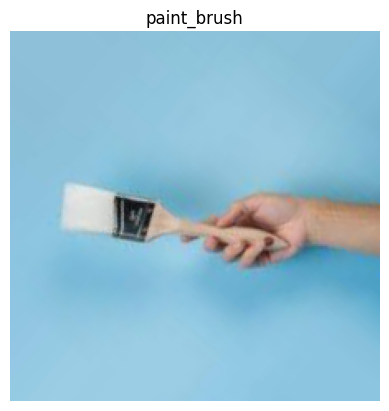

In [ ]:
display_random(images, labels)

## 2. Preprocesamiento

In [ ]:
grayscale_layer = tf.keras.layers.Lambda(tf.image.rgb_to_grayscale)
normalization_layer = tf.keras.layers.Rescaling(1. / 255)


def preprocess_entry(image, label):
  image = grayscale_layer(image)
  image = normalization_layer(image)
  return image, label


def preprocess_dataset(images, labels):
  images, labels = zip_apply(lambda x: itertools.starmap(preprocess_entry, x), images, labels)
  images = np.array(images).astype(np.float32)
  labels = np.array(labels).astype(np.uint32)
  return images, labels

## Data augmentation

# 3. Fase 1: Modelo propio

## 3.1 Dataset de entrenamiento y validación

In [ ]:
(train_images, train_labels), \
(val_images, val_labels) \
= split_dataset(images, labels, split=0.1)

unprocessed_train_images = train_images.copy()
unprocessed_train_labels = train_labels.copy()

unprocessed_val_images = val_images.copy()
unprocessed_val_labels = val_labels.copy()

train_images, train_labels = preprocess_dataset(train_images, train_labels)
val_images, val_labels = preprocess_dataset(val_images, val_labels)

print("Dimensión de imágenes de entrenamiento:", train_images.shape)
print("Dimension de etiquetas de entrenamiento:", train_labels.shape)
print()
print("Dimensión de imágenes de validación:", val_images.shape)
print("Dimension de etiquetas de validación:", val_labels.shape)

Dimensión de imágenes de entrenamiento: (6750, 224, 224, 1)
Dimension de etiquetas de entrenamiento: (6750,)

Dimensión de imágenes de validación: (750, 224, 224, 1)
Dimension de etiquetas de validación: (750,)


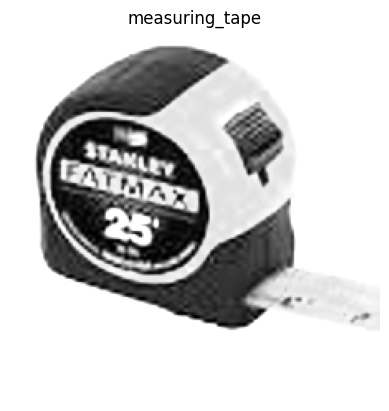

In [ ]:
display_random(val_images, val_labels)

In [ ]:
def model_paths(name: str):
  weights_path = os.path.join(path, f"out/models/{name}/checkpoints/weights")
  log_path = os.path.join(path, f"out/models/{name}/training.csv")
  return name, weights_path, log_path

In [ ]:
def model_summary(model):
  # Se valida el modelo utilizando el conjunto de datos de validación
  loss, accuracy = model.evaluate(val_images, val_labels, verbose=0)
  print("Validation loss:", loss)
  print("Validation accuracy:", f"{accuracy * 100:.2f}%")

  # Imprime un resumen del modelo, que muestra la arquitectura de la red, el 
  # número de parámetros entrenables y la forma de los datos en cada capa
  print(model.summary())

  # Muestra un diagrama de la arquitectura de la red.
  from keras.utils import plot_model
  plot_model(model, show_layer_names=True, show_layer_activations=True, show_shapes=True)

In [ ]:
# Carga de los pesos exportados en el entrenamiento del modelo
def load_model_weights(model, weights_path: str):
  model.load_weights(weights_path)
  return model

In [ ]:
input_shape = (*image_size, 1)
input_shape_rgb = (*image_size, 3)
num_classes = len(classes)

## 3.2 Construcción

In [ ]:
def build_custom_model():
  model = k.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
  ])

  model.compile(
    optimizer=k.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
  )

  return model

In [ ]:
def early_stopping_callback(epochs: int, monitor: str = "val_loss"):
  return tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=epochs)


# Define un objeto de registro que registra la información de la precisión
# y la pérdida del modelo durante el entrenamiento.
def logger_callback(path: str):
  return tf.keras.callbacks.CSVLogger(path, append=False)


def checkpoint_callback(path: str, monitor: str = "val_loss"):
  # Callback que guarda los pesos del modelo después de cada época.
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_weights_only=True,
    save_best_only=True,
    save_freq="epoch",
    monitor="val_loss",
    mode="auto",
    verbose=1,
  )

In [ ]:
model_name, weights_path, log_path = model_paths(name="custom")

def train_custom_model(model, epochs: int, batch_size: int):
  model.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=[
      logger_callback(log_path),
      checkpoint_callback(weights_path), 
      early_stopping_callback(epochs=5),
    ],
  )

  return model

In [ ]:
force_train = False  # `True` para forzar el entrenamiento del modelo, `False` para lo contrario
trained = os.path.isfile(f"{weights_path}.index")

custom_model = build_custom_model()

if did_train := (force_train or not trained):
  custom_model = train_custom_model(custom_model)
else:
  custom_model = load_model_weights(custom_model, weights_path)

model_summary(custom_model)

# 4. Fase 2: Modelos preentrenados y transfer learning

##Transfer learning 1: ResNet50

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_resnet_model():
  model = Sequential()

  resnet_model = tf.keras.applications.ResNet50(include_top=False,
                    input_shape=input_shape_rgb,
                    pooling='avg',classes=num_classes,
                    weights='imagenet')
  
  for layer in resnet_model.layers:
    layer.trainable=False

  # Agregar capa de conversión de escala de grises a 3 canales
  model.add(Conv2D(3, (1, 1), input_shape=(224, 224, 1), activation='relu'))

  model.add(resnet_model )
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
model_name, weights_path, log_path = model_paths(name="resnet")

def train_resnet_model(model):
  model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    callbacks=[
      logger_callback(log_path),
      checkpoint_callback(weights_path), 
      early_stopping_callback(epochs=3),
    ],
  )

  return model

In [ ]:
force_train = False  # `True` para forzar el entrenamiento del modelo, `False` para lo contrario
trained = os.path.isfile(f"{weights_path}.index")

resnet_model = build_resnet_model()

if did_train := (force_train or not trained):
  resnet_model = train_resnet_model(resnet_model)
else:
  resnet_model = load_model_weights(resnet_model, weights_path)

model_summary(resnet_model)

##Transfer learning 2: InceptionResNetV2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_inception_model():
  inception_model = keras.applications.InceptionResNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
  )

  model = keras.Sequential()

  model.add(Conv2D(3, (1, 1), input_shape=(224, 224, 1), activation='relu'))
  model.add(inception_model)
  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.Dense(256, activation="relu"))
  model.add(keras.layers.Dense(10, activation="softmax"))

  # Congelar las capas del modelo base
  inception_model.trainable = False

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model_name, weights_path, log_path = model_paths(name="inception")

def train_inception_model(model):
  model.fit(
    train_images,
    train_labels,
    epochs=20, 
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=[
      logger_callback(log_path),
      checkpoint_callback(weights_path), 
      early_stopping_callback(epochs=3),
    ],
  )

  return model

In [ ]:
force_train = False  # `True` para forzar el entrenamiento del modelo, `False` para lo contrario
trained = os.path.isfile(f"{weights_path}.index")

inception_model = build_inception_model()

if did_train := (force_train or not trained):
  inception_model = train_inception_model(inception_model)
else:
  inception_model = load_model_weights(inception_model, weights_path)

model_summary(inception_model)

##Transfer learning 3: VGG16 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def build_vgg_model():
  # Cargar el modelo preentrenado VGG16 sin la capa superior (clasificación)
  vgg_model = VGG16(
      weights="imagenet", include_top=False, input_shape=(224, 224, 3)
  )

  # Congelar las capas del modelo base
  for layer in vgg_model.layers:
    layer.trainable = False

  # Agregar capas adicionales para la clasificación
  model = keras.Sequential()
  model.add(Conv2D(3, (1, 1), input_shape=input_shape, activation='relu'))
  model.add(vgg_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(256, activation="relu"))
  model.add(keras.layers.Dense(10, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model_name, weights_path, log_path = model_paths(name="vgg")

def train_vgg_model(model):
  model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    batch_size=32, 
    validation_data=(val_images, val_labels),
    callbacks=[
      logger_callback(log_path),
      checkpoint_callback(weights_path), 
      early_stopping_callback(epochs=3),
    ],
  )

  return model

In [ ]:
force_train = False  # `True` para forzar el entrenamiento del modelo, `False` para lo contrario
trained = os.path.isfile(f"{weights_path}.index")

vgg_model = build_vgg_model()

if did_train := (force_train or not trained):
  vgg_model = train_vgg_model(vgg_model)
else:
  vgg_model = load_model_weights(vgg_model, weights_path)

model_summary(vgg_model)

##Transfer learning 4: DenseNet121

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D
from keras.layers import GlobalAveragePooling2D

def build_densenet_model():
  # Cargar el modelo DenseNet-121 preentrenado sin incluir las capas superiores (clasificador)
  densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Congelar las capas del modelo preentrenado
  for layer in densenet_model.layers:
    layer.trainable = False

  model = keras.Sequential()
  model.add(Conv2D(3, (1, 1), input_shape=input_shape, activation='relu'))
  model.add(densenet_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation="relu"))
  model.add(Dense(10, activation="softmax"))

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model_name, weights_path, log_path = model_paths(name="densenet")

def train_densenet_model(model):
  model.fit(
    train_images, 
    train_labels, 
    epochs=10, 
    batch_size=32, 
    validation_data=(val_images, val_labels),
    callbacks=[
      logger_callback(log_path),
      checkpoint_callback(weights_path), 
      early_stopping_callback(epochs=3),
    ],
  )

  return model

In [ ]:
force_train = False  # `True` para forzar el entrenamiento del modelo, `False` para lo contrario
trained = os.path.isfile(f"{weights_path}.index")

densenet_model = build_densenet_model()

if did_train := (force_train or not trained):
  densenet_model = train_densenet_model(densenet_model)
else:
  densenet_model = load_model_weights(densenet_model, weights_path)

model_summary(densenet_model)

# 5. Fase 3: Comparación de los modelos

In [ ]:
def plot_performance(log_path: str, title: str):
  history = pd.read_csv(log_path)
  history["epoch"] = history["epoch"] + 1
  
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
  
  # Gráfico de Precisión
  ax1 = axes[0]
  ax1.plot(history["epoch"], history["accuracy"])
  ax1.plot(history["epoch"], history["val_accuracy"])
  ax1.set_title("Precisión")
  ax1.set_ylabel("accuracy")
  ax1.set_xlabel("epoch")
  ax1.legend(["train", "val"], loc="upper left")
  
  # Gráfico de Pérdida
  ax2 = axes[1]
  ax2.plot(history["epoch"], history["loss"])
  ax2.plot(history["epoch"], history["val_loss"])
  ax2.set_title("Pérdida")
  ax2.set_ylabel("loss")
  ax2.set_xlabel("epoch")
  ax2.legend(["train", "val"], loc="upper left")
  
  plt.tight_layout()
  fig.suptitle(title, y=1.05, fontsize=14)
  plt.show()

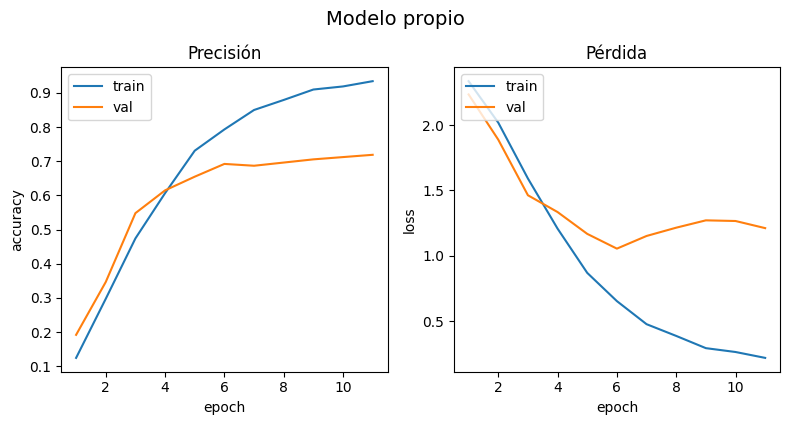

In [ ]:
plot_performance(log_path, title="Modelo propio")

In [ ]:
import io

def preprocess_external_image(image: bytes):
  image = io.BytesIO(image)
  image = pillow.Image.open(image)
  image = image.resize(image_size)
  image = np.array(image)
  image = preprocess_internal_image(image)
  return image


def preprocess_internal_image(image: np.ndarray):
  image = grayscale_layer(image)
  image = normalization_layer(image)
  image = np.expand_dims(image, axis=0)
  return image


# Clasificación de herramientas.
def classify_tool(model, image: bytes | np.ndarray):
  if isinstance(image, bytes):
    image = preprocess_external_image(image)
  elif isinstance(image, np.ndarray):
    image = preprocess_internal_image(image)

  # Arreglo de n=10, donde cada entrada i corresponde a la probabilidad de que 
  # el dígito sea el número i. 
  predictions = model.predict(image, verbose=0)

  digit = np.argmax(predictions)  # Índice del valor con la probabilidad más alta.
  score = np.max(predictions)     # Valor con la probabilidad más alta.
  return digit, score

In [ ]:
def compare_models(models):
  # TODO: Mostrar las clasificaciones de los 5 modelos 
  for model in models:
    image, label = random_image(unprocessed_val_images, unprocessed_val_labels)
    tool, score = classify_tool(model, image)
    print("Esperado:", classes[label])
    print("Obtenido:", classes[tool]) 
    print("Precisión:", f"{score:.5%}")
    display(image, label=classes[tool])

In [ ]:
def tabulate(df):
  with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)


def batch_classify(model, images, labels):
  for image, label in zip(images, labels):
    tool, score = classify_tool(model, image)
    yield label, tool, score


def classification(model, images, labels):
  columns = ["expected_class", "actual_class", "score"]

  data = batch_classify(model, images, labels)
  df = pd.DataFrame(data, columns=columns)

  missed_df = df[df["expected_class"] != df["actual_class"]]
  missed_df = missed_df.sort_values(by="score", ascending=False)

  print("Total clasificados:", total_classified := len(images))
  print("Total fallados:", total_missed := len(missed_df))
  print("Total fallados (%):", f"{(total_missed / total_classified) * 100:.2f}%")
  print("Total acertados (%):", f"{(1 - (total_missed / total_classified)) * 100:.2f}% (val_accuracy)")

  return df["expected_class"].to_numpy(), df["actual_class"].to_numpy()

In [ ]:
expected_classes, actual_classes \
= classification(custom_model, images=unprocessed_val_images, labels=unprocessed_val_labels)

Total clasificados: 750
Total fallados: 283
Total fallados (%): 37.73%
Total acertados (%): 62.27% (val_accuracy)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Crear una función para mostrar la matriz de confusión
def plot_confusion_matrix(expected_classes, actual_classes, classes):
  cm = confusion_matrix(expected_classes, actual_classes)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  
  thresh = cm.max() / 2
  for i, j in np.ndindex(cm.shape):
      plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
  
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Verdadera')
  plt.title('Matriz de Confusión')

  plt.show()

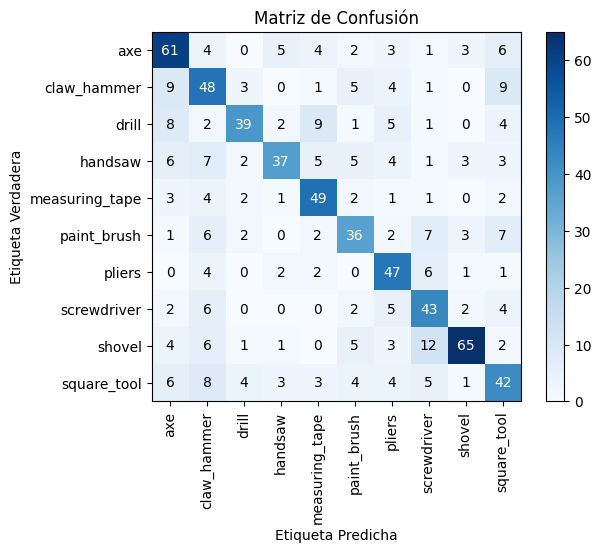

In [ ]:
plot_confusion_matrix(expected_classes, actual_classes, classes)

# 6. Fase 4: Frontend

Enlace externo: